# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

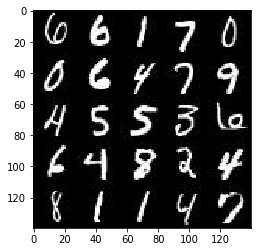

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

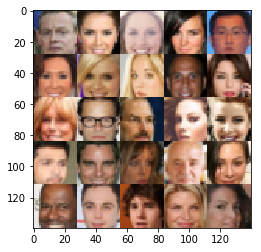

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learn_rate = tf.placeholder(tf.float32, (None), name='learn_rate')

    return real_input, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
                
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
                
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0090... Generator Loss: 11.3692
Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 8.3000
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 5.8310
Epoch 1/2... Discriminator Loss: 0.0977... Generator Loss: 3.6116
Epoch 1/2... Discriminator Loss: 1.9146... Generator Loss: 2.0067
Epoch 1/2... Discriminator Loss: 0.0880... Generator Loss: 3.3754
Epoch 1/2... Discriminator Loss: 1.8357... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.7560
Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 1.3330
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.7855


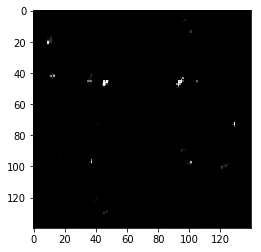

Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.7334
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.6998
Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 4.6408
Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 2.4600
Epoch 1/2... Discriminator Loss: 1.7502... Generator Loss: 0.2475
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.4102


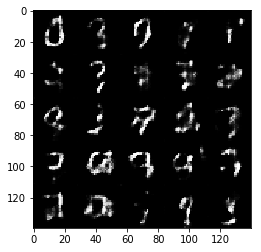

Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.7335... Generator Loss: 1.3119
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.2287
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 2.2640... Generator Loss: 0.1748
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.9038


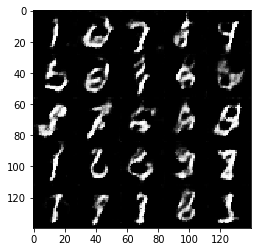

Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.6584
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 1.6489
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.7282
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.8843


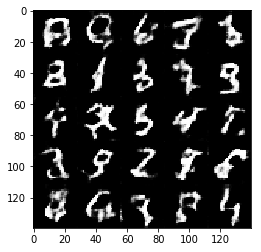

Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.8135
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.9351


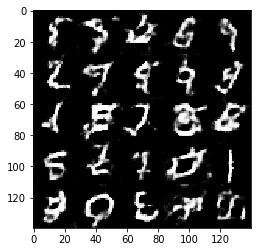

Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.6021
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 1.6040... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.6056
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.4983
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 2.1453


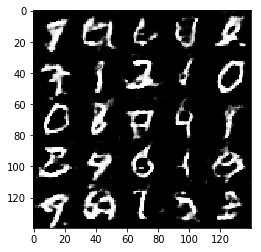

Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.2277
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.4305


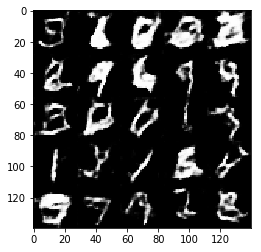

Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.7921
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 2.5429
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 0.8557... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.1551
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.3036


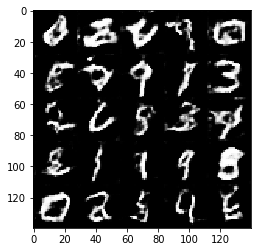

Epoch 1/2... Discriminator Loss: 0.6335... Generator Loss: 1.3534
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.3515
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 2.9077
Epoch 1/2... Discriminator Loss: 0.5512... Generator Loss: 2.3876
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 2.4243
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 2.8558
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 0.6118... Generator Loss: 1.5170


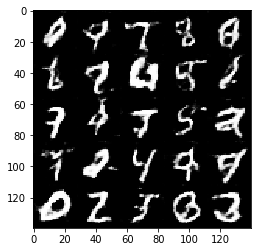

Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.3036
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.4366
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 2.3630
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 2.3652
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 2.0820
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 1.8716
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 4.0102


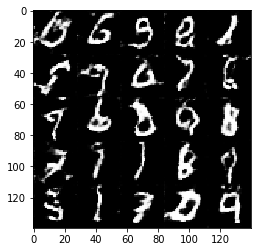

Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.7597
Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 1.4405
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.7230
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.6469
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.7794
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 1.9475
Epoch 2/2... Discriminator Loss: 0.4346... Generator Loss: 2.3995
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.2982
Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 1.4532


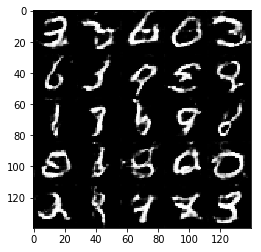

Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 2.4229
Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 2.3272
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.2019
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 1.9154
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.1885
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 2.1818
Epoch 2/2... Discriminator Loss: 0.3598... Generator Loss: 1.8986


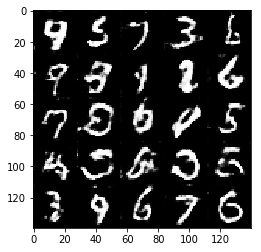

Epoch 2/2... Discriminator Loss: 0.3818... Generator Loss: 2.6684
Epoch 2/2... Discriminator Loss: 0.5159... Generator Loss: 3.3518
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 2.2732
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 1.9219
Epoch 2/2... Discriminator Loss: 0.5137... Generator Loss: 2.0460
Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.7406
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 2.2417
Epoch 2/2... Discriminator Loss: 0.3777... Generator Loss: 2.5720
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.0305
Epoch 2/2... Discriminator Loss: 0.3613... Generator Loss: 2.2481


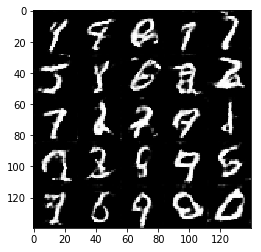

Epoch 2/2... Discriminator Loss: 1.5518... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 2.0779
Epoch 2/2... Discriminator Loss: 0.3127... Generator Loss: 2.4862
Epoch 2/2... Discriminator Loss: 0.3842... Generator Loss: 1.8182
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 2.7669
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 3.2639
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 0.4105... Generator Loss: 1.8261
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 3.2403
Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 1.3384


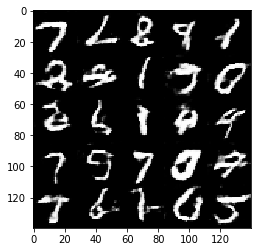

Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 3.7382
Epoch 2/2... Discriminator Loss: 0.6242... Generator Loss: 1.4937
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 2.4866
Epoch 2/2... Discriminator Loss: 0.3903... Generator Loss: 2.0945
Epoch 2/2... Discriminator Loss: 0.2699... Generator Loss: 2.5888
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 3.0850
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.2119
Epoch 2/2... Discriminator Loss: 0.2637... Generator Loss: 3.0622
Epoch 2/2... Discriminator Loss: 0.4297... Generator Loss: 2.6224
Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 2.9503


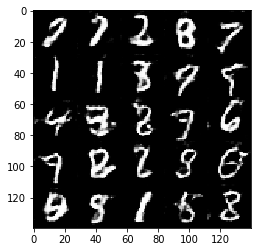

Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 3.2029
Epoch 2/2... Discriminator Loss: 0.2845... Generator Loss: 2.2793
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 2.2513
Epoch 2/2... Discriminator Loss: 0.2681... Generator Loss: 3.0538
Epoch 2/2... Discriminator Loss: 0.2070... Generator Loss: 2.7079
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.5879
Epoch 2/2... Discriminator Loss: 0.3111... Generator Loss: 2.5144
Epoch 2/2... Discriminator Loss: 0.2470... Generator Loss: 3.2617
Epoch 2/2... Discriminator Loss: 0.3044... Generator Loss: 1.4901


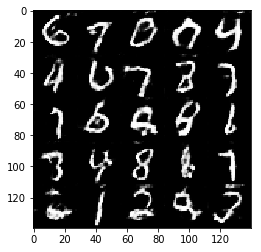

Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 3.4232
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.5812
Epoch 2/2... Discriminator Loss: 0.5908... Generator Loss: 1.3880
Epoch 2/2... Discriminator Loss: 0.2421... Generator Loss: 2.1985
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.2401... Generator Loss: 2.7113
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 3.7042
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 3.8166
Epoch 2/2... Discriminator Loss: 0.1619... Generator Loss: 3.7054
Epoch 2/2... Discriminator Loss: 5.5455... Generator Loss: 8.9238


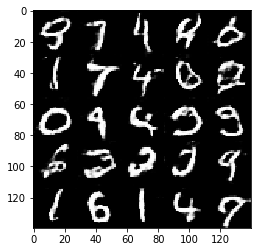

Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.7358
Epoch 2/2... Discriminator Loss: 0.6066... Generator Loss: 3.1109
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 1.6214
Epoch 2/2... Discriminator Loss: 0.2846... Generator Loss: 2.4794
Epoch 2/2... Discriminator Loss: 0.3611... Generator Loss: 2.0228
Epoch 2/2... Discriminator Loss: 0.3158... Generator Loss: 2.0282
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.1548
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 0.2597... Generator Loss: 2.7431
Epoch 2/2... Discriminator Loss: 0.1398... Generator Loss: 2.2539


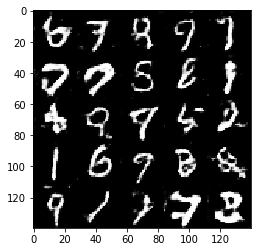

Epoch 2/2... Discriminator Loss: 0.2107... Generator Loss: 3.4426
Epoch 2/2... Discriminator Loss: 0.1904... Generator Loss: 3.6671
Epoch 2/2... Discriminator Loss: 0.1575... Generator Loss: 2.8287
Epoch 2/2... Discriminator Loss: 0.2389... Generator Loss: 3.9154
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 1.9499
Epoch 2/2... Discriminator Loss: 0.2171... Generator Loss: 3.2245
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 0.9777


In [ ]:
batch_size = 64
z_dim = 100
#z_dim = 28*28
learning_rate = 0.001
#learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 6.3533
Epoch 1/1... Discriminator Loss: 5.6902... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 2.6905
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 2.8445
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 2.2689
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 4.2496
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 0.2070... Generator Loss: 2.5953
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 3.8069


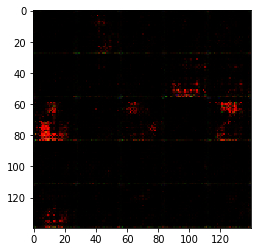

Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 7.2906
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 6.2229
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 3.1649
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.8566


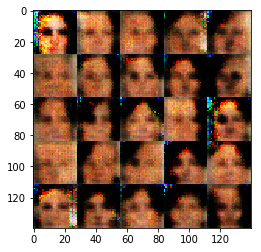

Epoch 1/1... Discriminator Loss: 1.8634... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 2.9581


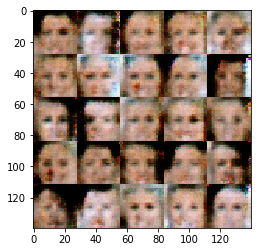

Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.7322
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 2.3683
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3504


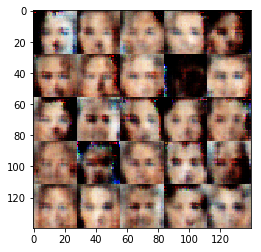

Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.4434
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 2.3814
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.6085


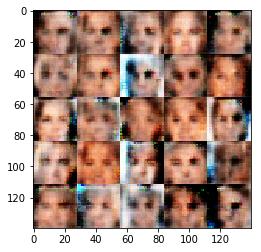

Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.9790
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.7896


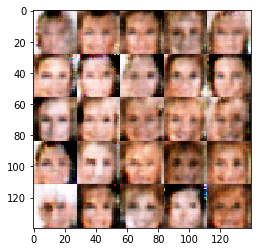

Epoch 1/1... Discriminator Loss: 4.3372... Generator Loss: 5.9202
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2602


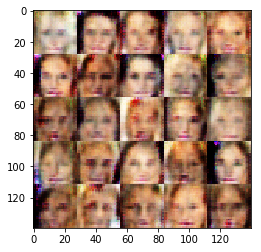

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.3087
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 1.6083


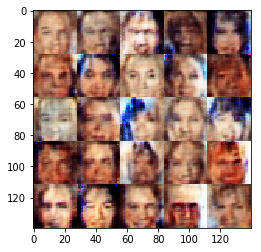

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 2.0706
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.1942


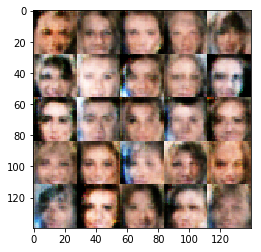

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7370


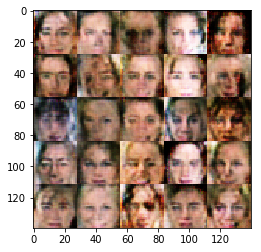

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.8572


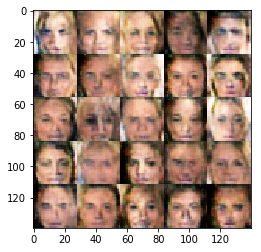

Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5414


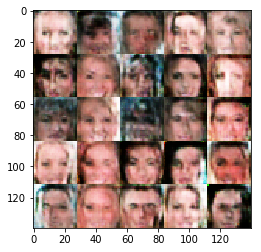

Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.1444


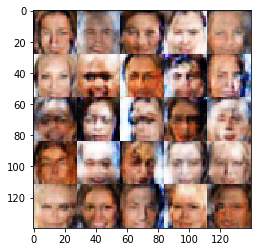

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6393


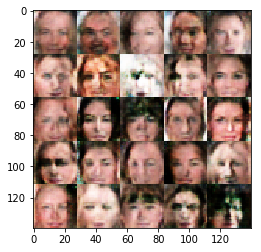

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6353


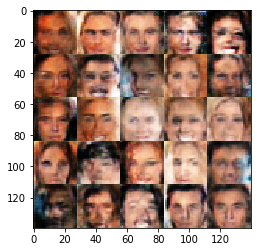

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0196


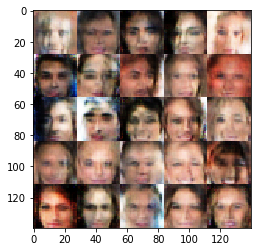

Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6397


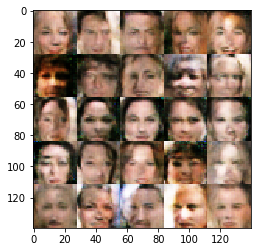

Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0914


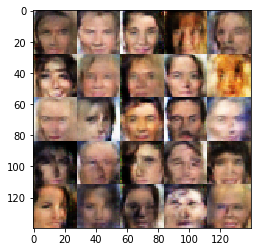

Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6764


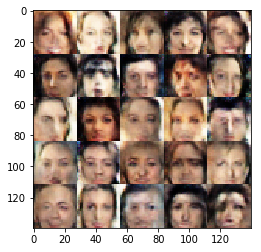

Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.3241
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.5899


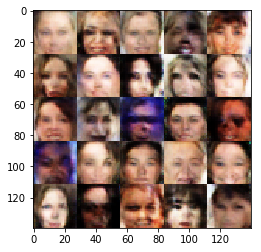

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.6129
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.0965


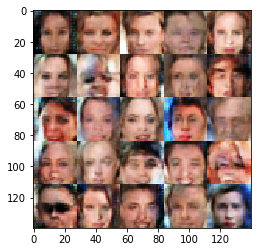

Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0785


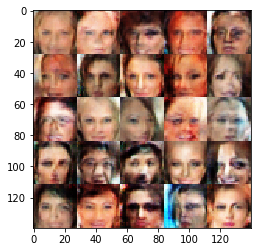

Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6831


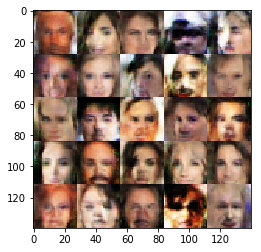

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.3894
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9824


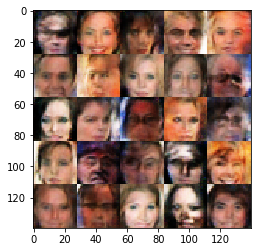

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7962


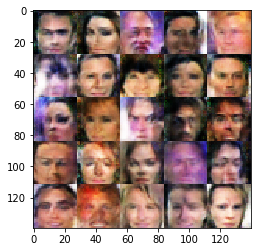

Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.6198


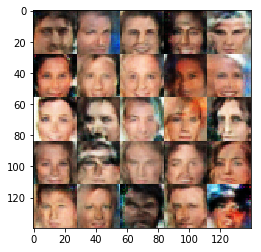

Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.7926
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.4045


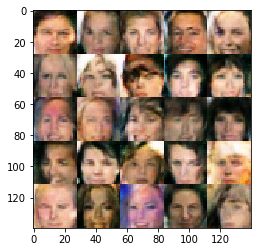

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0914


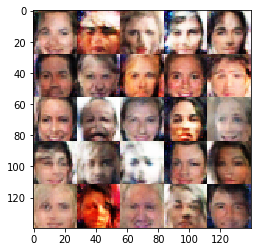

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.5538


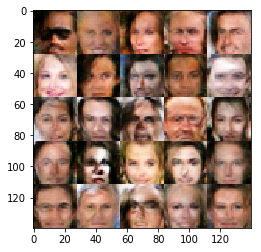

Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.3821


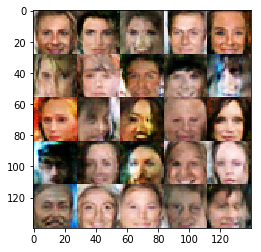

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.2999
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.1433


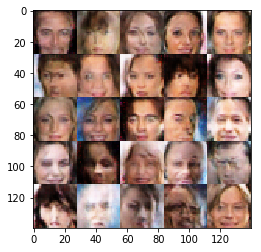

Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9102


In [ ]:
batch_size = 64
z_dim = 100
#z_dim = 28*28
learning_rate = 0.001
#learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.